### IFDI calculator demonstration

#### Pre-requisites:

You will need to install the following:
 * Jupyter
 * Python3
 * numpy/scipy/glob/matplotlib - we recommend using Anaconda to install of these packages

The code is provided as an example. It is based on several assumptions and is provided as a starting point for you to adapt for your own purposes. Here is a non-exhaustive list:
 * You are reading data from geometry scans where a torsion angle was incremented in 10 degree steps
 * Your data directory contains a series of files ending "LIDI.txt" and "mwfn.out" generated by Multiwfn. These files are ordered such that, when sorted alphanumerically, the first file describes the first step in a torsion scan, and so on.
 * The first step corresponds to a torsion angle of zero degrees

The most useful function for the user is likely to be "readLIDIFile" which reads the -LIDI.txt file and converts it into a numpy array.

In [1]:

# import necessary packages
import numpy as np
import scipy as sp
import glob,os,re
import matplotlib
import matplotlib.pyplot as plt
#set some matplotlib defaults
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 7})


# This function reads a LIDI output file (filename ending "LIDI.txt") produced by Multiwfn
def readLIDIFile(lioutfile,endstr=' Localization index'):
    
    # First we find the end of the delocalization index matrix, indicated by the start of the "Localization index" section
    # (i.e. the string in endstr)
    with open(lioutfile, "r") as ff:
        data = ff.readlines()

    if endstr is None:
        endline = len(data)
    else:
        for ii,line in enumerate(data):        
            if re.match(endstr,line):
                endline=ii-1
    data = data[0:endline]

        
    # find number of atoms in file
    for ii,line in enumerate(data[2:]):
        if re.match('^\s*\d+\s*\d+\s*\d+\s*\d+\s*\d+\s*$',line):
            natom=ii
            break
    dd = np.zeros((natom,natom))
     
    # read the datablocks from the output file into an array
    for ii,line in enumerate(data[2:]):
        if len(line[:6].strip()) > 0:
            block = ii//(natom+1)
            data = [float(i) for i in line[6:].split()]
            atomid = (ii%(natom+1))
            dd[atomid,5*block:5*block+5] = data

    return dd

# This function recovers the electronic energy from the multiwfn logfile (ending -mwfn.out)
def getEnergyFromMwfn(outfile):
    energy = False
    with open(outfile, "r") as ff:
        for line in ff:
            if "Total energy:" in line:
                #  Total energy:   -4989.509474461608 Hartree,   Virial ratio:  2.00472605
                energy = float(line.split()[2])
                break

    return energy


# This class is for a cDFT data (i.e. LIDI) associated with a scan. It contains methods to read the LIDI 
# files, which must be named according to {anything}_001_LIDI.txt   (incrementing 001 for each
# step). 

# The class is used to read in data for, and generate plots for, the LIDI between two "halves" of a dimer. So it is
# typical to define the indices (note: zero indexing!) of the left hand side (LHS) and right hand side (RHS) atoms, excluding
# the bridge. 

class cdftScan():
    
    def __init__(self,title,elec,geom,folder,LHSAtoms=[],RHSAtoms=[]):
        self.title = title
        self.elecFunc = elec
        self.geomFunc = geom
        self.folder = folder
        self.LHSAtoms = LHSAtoms
        self.RHSAtoms = RHSAtoms
        self.energies = None
        
    
    def readLIDI(self):
        os.chdir(self.folder)
        ff = glob.glob('*LIDI.txt')
        lidi = []
        for file in sorted(ff):
            lidiN = readLIDIFile(file) 
            lidi.append(lidiN)
            #lidi.append(removeH(lidiN,atoms))
        self.lidi = lidi

    def readEnergy(self):
        os.chdir(self.folder)
        ff = glob.glob("*-mwfn.out")
        energies = []
        for file in sorted(ff):
            ee = getEnergyFromMwfn(file)
            energies.append(ee)
        
        self.energies = energies
        

    def getEnergies(self,units='Hartree', relative=True):
        if self.energies is None:
            self.readEnergy()
        ee = self.energies
        if relative is True:
            ee = ee - np.min(ee)
        if units=='Hartree':
            return ee
        if units =='kcal':
            return 627.5*ee
        if units == 'kJ':
            return 2625.5*ee
    
    def setAtomArgs(self,LHSAtoms,RHSAtoms):
        if LHSAtoms is None:
            LHSAtoms = self.LHSAtoms
        if RHSAtoms is None:
            RHSAtoms = self.RHSAtoms
        return LHSAtoms,RHSAtoms
    
    # Plots LIDI scan vs angle
    def plotScan(self,data,LHSAtoms=None,RHSAtoms=None,startParam=0,increment=10,labelBoth=True): 
        LHSAtoms,RHSAtoms = self.setAtomArgs(LHSAtoms,RHSAtoms)
        LtoR = self.getOffdiag(data,LHSAtoms,RHSAtoms)
        maxangle = (len(LtoR) * 10) + startParam
        if labelBoth is True:
            ll = "{}//{}".format(self.elecFunc,self.geomFunc)
        else:
            ll = "{}".format(self.elecFunc)

        ll=ll.replace("w","$\omega{}\,$")
        plt.plot(np.arange(0,maxangle,10),LtoR,'o-', label=ll)

    # gets value of off-diagonal elements between left hand side and right-hand-side 
    def getOffdiag(self,data,LHSAtoms=None,RHSAtoms=None):
        LHSAtoms,RHSAtoms = self.setAtomArgs(LHSAtoms,RHSAtoms)
        LtoR = []
        for dd in data:

            offdiag = dd[np.ix_(LHSAtoms,RHSAtoms)]
            LtoR.append(np.sum(offdiag))
        return LtoR        
    
    # plots a LIDI scan - wrapper on plotScan
    def plotLIDIScan(self,LHSAtoms=None,RHSAtoms=None,startParam=0,increment=10,newFig=True,labelBoth=True):
        LHSAtoms,RHSAtoms = self.setAtomArgs(LHSAtoms,RHSAtoms)
        if newFig:
            plt.figure()
        self.plotScan(self.lidi,LHSAtoms,RHSAtoms,startParam=0,increment=10,labelBoth=labelBoth)
        plt.title('LIDI -- survey')
        plt.xlabel('Angle (deg)')
        plt.ylabel('LIDI between sides')    
        plt.xlim([0,180])
        plt.legend()
        
    # prints a string of results for the LIDI/torsion data
    def printResults(self,LHSAtoms=None,RHSAtoms=None,minimax=False):
        LHSAtoms,RHSAtoms = self.setAtomArgs(LHSAtoms,RHSAtoms)
        od = self.getOffdiag(self.lidi,LHSAtoms,RHSAtoms)
        ee = self.getEnergies(units='kJ')
        if minimax is True:
            print('Method: {}   DeltaLIDI: {:.4e}     LIDIMax: {:.4e}     Torsion: {:.4e} kJ/mol'.format(self.elecFunc,np.max(od)-np.min(od),np.max(od),np.max(ee)-np.min(ee)))
        else:
            # assume that increments are 10 degrees, starting at 0 degrees. Therefore the 9th index is 90 deg
            print('Method: {}   DeltaLIDI: {:.4e}     LIDIMax: {:.4e}     Torsion: {:.4e} kJ/mol'.format(self.elecFunc,od[0]-od[9],np.max(od),ee[9]-ee[0]))
    
    # returns the DIFDI (with arguements as above for printResults) as a float
    def getDIFDI(self,LHSAtoms=None,RHSAtoms=None,minimax=False):
            od = self.getOffdiag(self.lidi,LHSAtoms,RHSAtoms)

            if minimax is True:
                return np.max(od)-np.min(od)
            else:
                return od[9]-od[0]

            
    # plots a torsion profile
    def plotTorsion(self,startParam=0,increment=10,newFig=True,labelBoth=True):
        if newFig:
            plt.figure()
        ee = self.getEnergies('kJ')
        maxangle = (len(ee) * 10) + startParam
        if labelBoth is True:
            ll = "{}//{}".format(self.elecFunc,self.geomFunc)
        else:
            ll = "{}".format(self.elecFunc)
        plt.plot(np.arange(0,maxangle,10),self.getEnergies('kJ'),'.',label=ll)

    # checking function: prints a list of atom numbers for LHS and RHS fragments. This is useful to make sure 
    # that mistakes have not been made. Note that +1 is added to the atom indices, to correspond to the
    # convention of using 1-indexing when labelling atoms on molecular displays
    def printAtomNos(self):
        print("########################################")
        print("{} {} {}".format(self.title,self.elecFunc,self.geomFunc))
        print("LHS atoms (1-indexed): {}".format(self.LHSAtoms+1))
        print("RHS atoms (1-indexed): {}".format(self.RHSAtoms+1))
        print("########################################")



In [2]:
# first define the *full path* to your data parent directory (i.e the directory in which all other data directories reside)

# parentdir = r"C:\Users\test\demo"
# figdir = r"C:\Users\test\demo"
parentdir = os.getcwd()
figdir = os.getcwd()

Method: B3LYP   DeltaLIDI: 1.1215e-02     LIDIMax: 2.4312e-02     Torsion: 1.1388e+00 kJ/mol


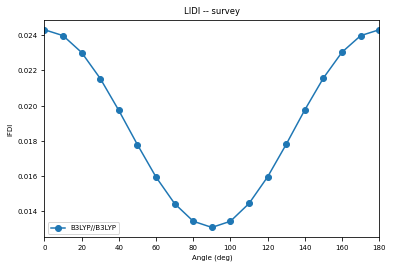

In [4]:
dpdadir = parentdir + r"\demo" 
os.chdir(dpdadir)

# typically we process several datasets in one loop (as shown below). This list contains data series calculated with different computational methods.
# for simiplicity, we have truncated this list to contain just one dataset.
methods = [ {'title': 'DPDA', 'elec': 'B3LYP', 'geom':'B3LYP', 'dir': 'b3lyp'},
            ]

# here are the indices of atoms on LHS and RHS
LHSAtoms = np.arange(16,27)-1
RHSAtoms = np.arange(1,12)-1
bridgeAtoms = np.arange(12,16)-1


# then we create the object cdftScan and put it into a list called "data"
data = []
for method in methods:
    # new object from cdftScan class as a new list element in 'data'
    data.append(cdftScan( method['title'], method['elec'], method['geom'], dpdadir+r"\{}".format(method['dir']),LHSAtoms=LHSAtoms,RHSAtoms=RHSAtoms))
    # read the cDFT files from the latest entry in the data list (which is, as shown in the line above, a cdftScan object)
    data[-1].readLIDI()
    
dpdadata = data
plt.figure()

for dd in data:
    # newFig=False because we already have done plt.figure (there are much better ways to do this but this works - essentially
    # it lets us put many lines on one graph. We should be doing this using a more object-oriented approach)
    dd.plotLIDIScan(newFig=False) 


    dd.printResults()


plt.ylabel('IFDI')
plt.legend()

plt.show()


In [5]:

dataitem = data[-1]
print("Here is the LIDI Matrix for the first geometry")
print(dataitem.lidi[0])

print("")
print("And here are the energies for each geometry (in relative kJ/mol )")
print(dataitem.getEnergies(units='kJ'))

Here is the LIDI Matrix for the first geometry
[[4.42265930e+00 1.34912588e+00 9.89504400e-02 8.83366700e-02
  9.89504600e-02 1.34912708e+00 4.03839000e-02 7.99851000e-03
  2.29707000e-03 7.99849000e-03 4.03839300e-02 1.21166627e+00
  1.01073160e-01 1.01834200e-02 1.17882000e-02 1.20327000e-03
  1.01541000e-03 1.01542000e-03 1.78030000e-04 2.36000000e-05
  1.78030000e-04 2.36000000e-05 7.16030000e-04 1.22300000e-05
  1.22300000e-05 1.79900000e-05]
 [1.34912588e+00 4.21327576e+00 1.48186405e+00 1.03974120e-01
  9.68443400e-02 8.92945500e-02 8.60070000e-01 4.56289800e-02
  8.11234000e-03 2.49323000e-03 7.72659000e-03 1.00731350e-01
  4.45377800e-02 4.72854000e-03 1.20735400e-02 1.01542000e-03
  1.54356000e-03 1.53975000e-03 2.35080000e-04 3.16200000e-05
  2.34560000e-04 3.21200000e-05 1.38930000e-03 7.48000000e-06
  6.85000000e-06 3.47400000e-05]
 [9.89504400e-02 1.48186405e+00 4.23355237e+00 1.45460521e+00
  1.04286580e-01 9.68443100e-02 4.27687300e-02 8.75351480e-01
  4.48067700e-02 8.